# Resources

* [lazyprogrammer](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/ann_class2/dropout_tensorflow.py)

* [Regularization in deep learning](https://chatbotslife.com/regularization-in-deep-learning-f649a45d6e0)

In [22]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn as sk
import tensorflow as tf

In [41]:
def get_normalized_data():
    df = pd.read_csv('../datasets/mnist/train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    Y = data[:,0]
    X = data[:,1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std==0, 1)
    X = (X-mu)/std
    return X, Y

In [39]:
class HiddenLayer:
    def __init__(self, M1, M2):
        self.M1 = M1
        self.M2 = M2
        W, b = HiddenLayer.xavier_init([self.M1, self.M2])
        self.W = tf.Variable(W)
        self.b = tf.Variable(b)
        self.params = [self.W, self.b]
        
    def forward(self, X):
        return tf.nn.relu( tf.matmul(X,self.W)+self.b )
    
    @staticmethod
    def xavier_init(size):
        if isinstance(size, collections.Iterable):
            xavier_stddev = 1.0 / tf.sqrt(size[0]/2.0)
            W = tf.random_normal(shape=size, stddev=xavier_stddev)
            W = tf.cast(W, tf.float32)
            b = tf.zeros(size[1])
            b = tf.cast(b, tf.float32)
            return W, b

In [99]:
class ANN:
    def __init__(self, hidden_layers, p_keep):
        self.hidden_layers_sizes = hidden_layers
        self.dropout_rates = p_keep
        
    def fit(self, X, Y, lr=1.0e-3, reg=1.0e-2, decay=0.999, momentum=0.9, epochs=300, 
            batch_size=300, print_period=50):
        # model validation
        X, Y = sk.utils.shuffle(X, Y)
        X = X.astype(np.float32)
        K = len(set(Y))

        Xtrain = X[:-1000,]                                                         
        Ytrain = Y[:-1000]                                                          
        Xtest  = X[-1000:,]                                                         
        Ytest  = Y[-1000:]                                                          
        Ytrain_ind = ANN.y2indicator(Ytrain, K=K)                                            
        Ytest_ind = ANN.y2indicator(Ytest, K=K)
            
        # Initialize hidden layers
        N, D = Xtrain.shape
        self.hidden_layers = []
        M1 = D
        for M2 in self.hidden_layers_sizes:
            h = HiddenLayer(M1, M2)
            self.hidden_layers.append(h)
            M1 = M2
        W, b = HiddenLayer.xavier_init([M1, K])
        self.W = tf.Variable(W)
        self.b = tf.Variable(b)
        
        # collect params
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params
          
        # set up 
        inputs = tf.placeholder(tf.float32, shape=[None, D], name='inputs')
        labels_ind = tf.placeholder(tf.float32, shape=[None, K], name='labels_ind')
        logits = self.forward(inputs)
        
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_ind)
        ) + (reg * sum([tf.nn.l2_loss(p) for p in self.params]))
        #train_op = tf.train.GradientDescentOptimizer(lr).minimize(cost)
        #train_op = tf.train.MomentumOptimizer(lr, momentum=momentum).minimize(cost)
        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=momentum).minimize(cost)
        prediction = self.predict(inputs)
        
        costs = []
        n_batches = N//batch_size
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                for j in range(n_batches):
                    batch_range = (j*batch_size, j*batch_size + batch_size)
                    Xbatch = Xtrain[batch_range[0]:batch_range[1], ]                
                    Ybatch = Ytrain_ind[batch_range[0]:batch_range[1], ]

                    session.run(train_op, feed_dict={inputs: Xbatch, labels_ind: Ybatch})
                    
                if i % print_period == 0:
                    test_cost = session.run(cost, 
                                            feed_dict={inputs: Xtest, labels_ind: Ytest_ind})
                    predictions = session.run(prediction, feed_dict={inputs: Xtest})
                    costs.append(test_cost)
                    err = ANN.error(predictions, Ytest)
                    print("Iteration {} out of {}. Cost: {:.3f},  err: {:.3f}"
                          .format(i, epochs, test_cost, err))
        return costs
        
    def forward(self, X):
        Z = X
        Z = tf.nn.dropout(Z, self.dropout_rates[0])
        for h, p in zip(self.hidden_layers, self.dropout_rates[1:]):
            Z = h.forward(Z)
            Z = tf.nn.dropout(Z, p)
        return tf.matmul(Z,self.W)+self.b
    
    def predict(self, X):
        pY = self.forward(X)
        return tf.argmax(pY, 1)
    
    @staticmethod
    def error(p, t):
        return np.mean(p!=t)
    
    @staticmethod
    def y2indicator(Y, K=10): # K=10 for MNIST
        N = len(Y)
        Y = Y.astype(np.int32)
        ind = np.zeros((N, K))
        for i in range(N):
            ind[i, Y[i]] = 1
        return ind

In [102]:
X, Y = get_normalized_data()
ann = ANN([200, 100, 50], [0.8, 0.5, 0.5, 0.5])
costs = ann.fit(X, Y, lr=1.0e-5, decay=0.99, momentum=0.9, epochs=100, batch_size=500, print_period=10)

Iteration 0 out of 100. Cost: 5.989,  err: 0.894
Iteration 10 out of 100. Cost: 2.570,  err: 0.784
Iteration 20 out of 100. Cost: 1.287,  err: 0.396
Iteration 30 out of 100. Cost: 0.817,  err: 0.258
Iteration 40 out of 100. Cost: 0.699,  err: 0.186
Iteration 50 out of 100. Cost: 0.580,  err: 0.152
Iteration 60 out of 100. Cost: 0.547,  err: 0.145
Iteration 70 out of 100. Cost: 0.486,  err: 0.127
Iteration 80 out of 100. Cost: 0.463,  err: 0.114
Iteration 90 out of 100. Cost: 0.490,  err: 0.114


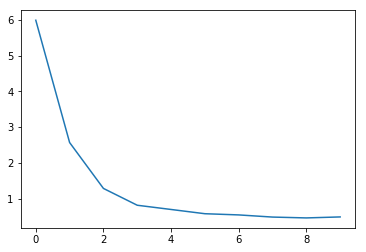

In [103]:
plt.plot(costs)
plt.show()